In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
image_dir = Path('Images/')

In [3]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
print(filepaths)

[WindowsPath('Images/apple/Image_1.jpg'), WindowsPath('Images/apple/Image_10.jpg'), WindowsPath('Images/apple/Image_16.jpg'), WindowsPath('Images/apple/Image_17.jpg'), WindowsPath('Images/apple/Image_18.jpg'), WindowsPath('Images/apple/Image_19.jpg'), WindowsPath('Images/apple/Image_2.jpg'), WindowsPath('Images/apple/Image_20.jpg'), WindowsPath('Images/apple/Image_21.jpg'), WindowsPath('Images/apple/Image_23.jpg'), WindowsPath('Images/apple/Image_24.jpg'), WindowsPath('Images/apple/Image_25.jpg'), WindowsPath('Images/apple/Image_26.jpg'), WindowsPath('Images/apple/Image_27.jpg'), WindowsPath('Images/apple/Image_28.jpg'), WindowsPath('Images/apple/Image_3.jpg'), WindowsPath('Images/apple/Image_31.jpg'), WindowsPath('Images/apple/Image_32.jpg'), WindowsPath('Images/apple/Image_33.jpg'), WindowsPath('Images/apple/Image_34.jpg'), WindowsPath('Images/apple/Image_36.jpg'), WindowsPath('Images/apple/Image_37.jpg'), WindowsPath('Images/apple/Image_38.jpg'), WindowsPath('Images/apple/Image_39.j

In [4]:
os.path.split(filepaths[0])[0].split('\\')[1]

'apple'

In [5]:
def mysplit(s):
    head = s.rstrip('0123456789')
    tail = s[len(head):]
    return head
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x:((os.path.split(x)[0]).split('\\')[1]), filepaths))
print(labels)
print(filepaths)
truelabels = []
for x in labels:
    truelabels.append(mysplit(x))

['apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana'

In [6]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(truelabels, name='Label')
images = pd.concat([filepaths, labels], axis=1)


In [7]:

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(36, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [8]:
image_df

,Filepath,Label
0,Images\pomegranate\Image_57.jpg,pomegranate
1,Images\lettuce\Image_8.jpg,lettuce
2,Images\banana\Image_40.jpg,banana
3,Images\pomegranate\Image_33.jpg,pomegranate
4,Images\pomegranate\Image_41.jpg,pomegranate
...,...,...
1291,Images\mango\Image_53.jpg,mango
1292,Images\pineapple\Image_95.jpg,pineapple
1293,Images\spinach\Image_18.jpg,spinach
1294,Images\carrot\Image_91.jpg,carrot


In [9]:
image_df['Label'].value_counts()


Label
pomegranate      36
lettuce          36
paprika          36
tomato           36
turnip           36
grapes           36
orange           36
cucumber         36
capsicum         36
chilli pepper    36
onion            36
sweetpotato      36
corn             36
spinach          36
peas             36
apple            36
watermelon       36
carrot           36
ginger           36
pineapple        36
raddish          36
banana           36
kiwi             36
bell pepper      36
garlic           36
eggplant         36
potato           36
jalepeno         36
beetroot         36
sweetcorn        36
cabbage          36
mango            36
lemon            36
cauliflower      36
soy beans        36
pear             36
Name: count, dtype: int64

In [10]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 726 validated image filenames belonging to 36 classes.
Found 181 validated image filenames belonging to 36 classes.
Found 389 validated image filenames belonging to 36 classes.


In [13]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


In [14]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [15]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)



Epoch 1/100


23/23 [==============================] - 39s 2s/step - loss: 3.1706 - accuracy: 0.2190 - val_loss: 2.4163 - val_accuracy: 0.4586
Epoch 2/100
23/23 [==============================] - 28s 1s/step - loss: 1.4473 - accuracy: 0.6736 - val_loss: 1.2797 - val_accuracy: 0.5967
Epoch 3/100
23/23 [==============================] - 28s 1s/step - loss: 0.6293 - accuracy: 0.8361 - val_loss: 1.1253 - val_accuracy: 0.6188
Epoch 4/100
23/23 [==============================] - 28s 1s/step - loss: 0.3397 - accuracy: 0.9229 - val_loss: 0.9685 - val_accuracy: 0.6740
Epoch 5/100
23/23 [==============================] - 28s 1s/step - loss: 0.1579 - accuracy: 0.9821 - val_loss: 0.8948 - val_accuracy: 0.6851
Epoch 6/100
23/23 [==============================] - 28s 1s/step - loss: 0.1032 - accuracy: 0.9821 - val_loss: 0.8961 - val_accuracy: 0.7017
Epoch 7/100
23/23 [==============================] - 29s 1s/step - loss: 0.0649 - accuracy: 0.9931 - val_loss: 0.8133 - val_accuracy: 0.7293
Epoch 8/10

In [16]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


Test Accuracy: 68.89%


In [17]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)


13/13 [==============================] - 13s 910ms/step


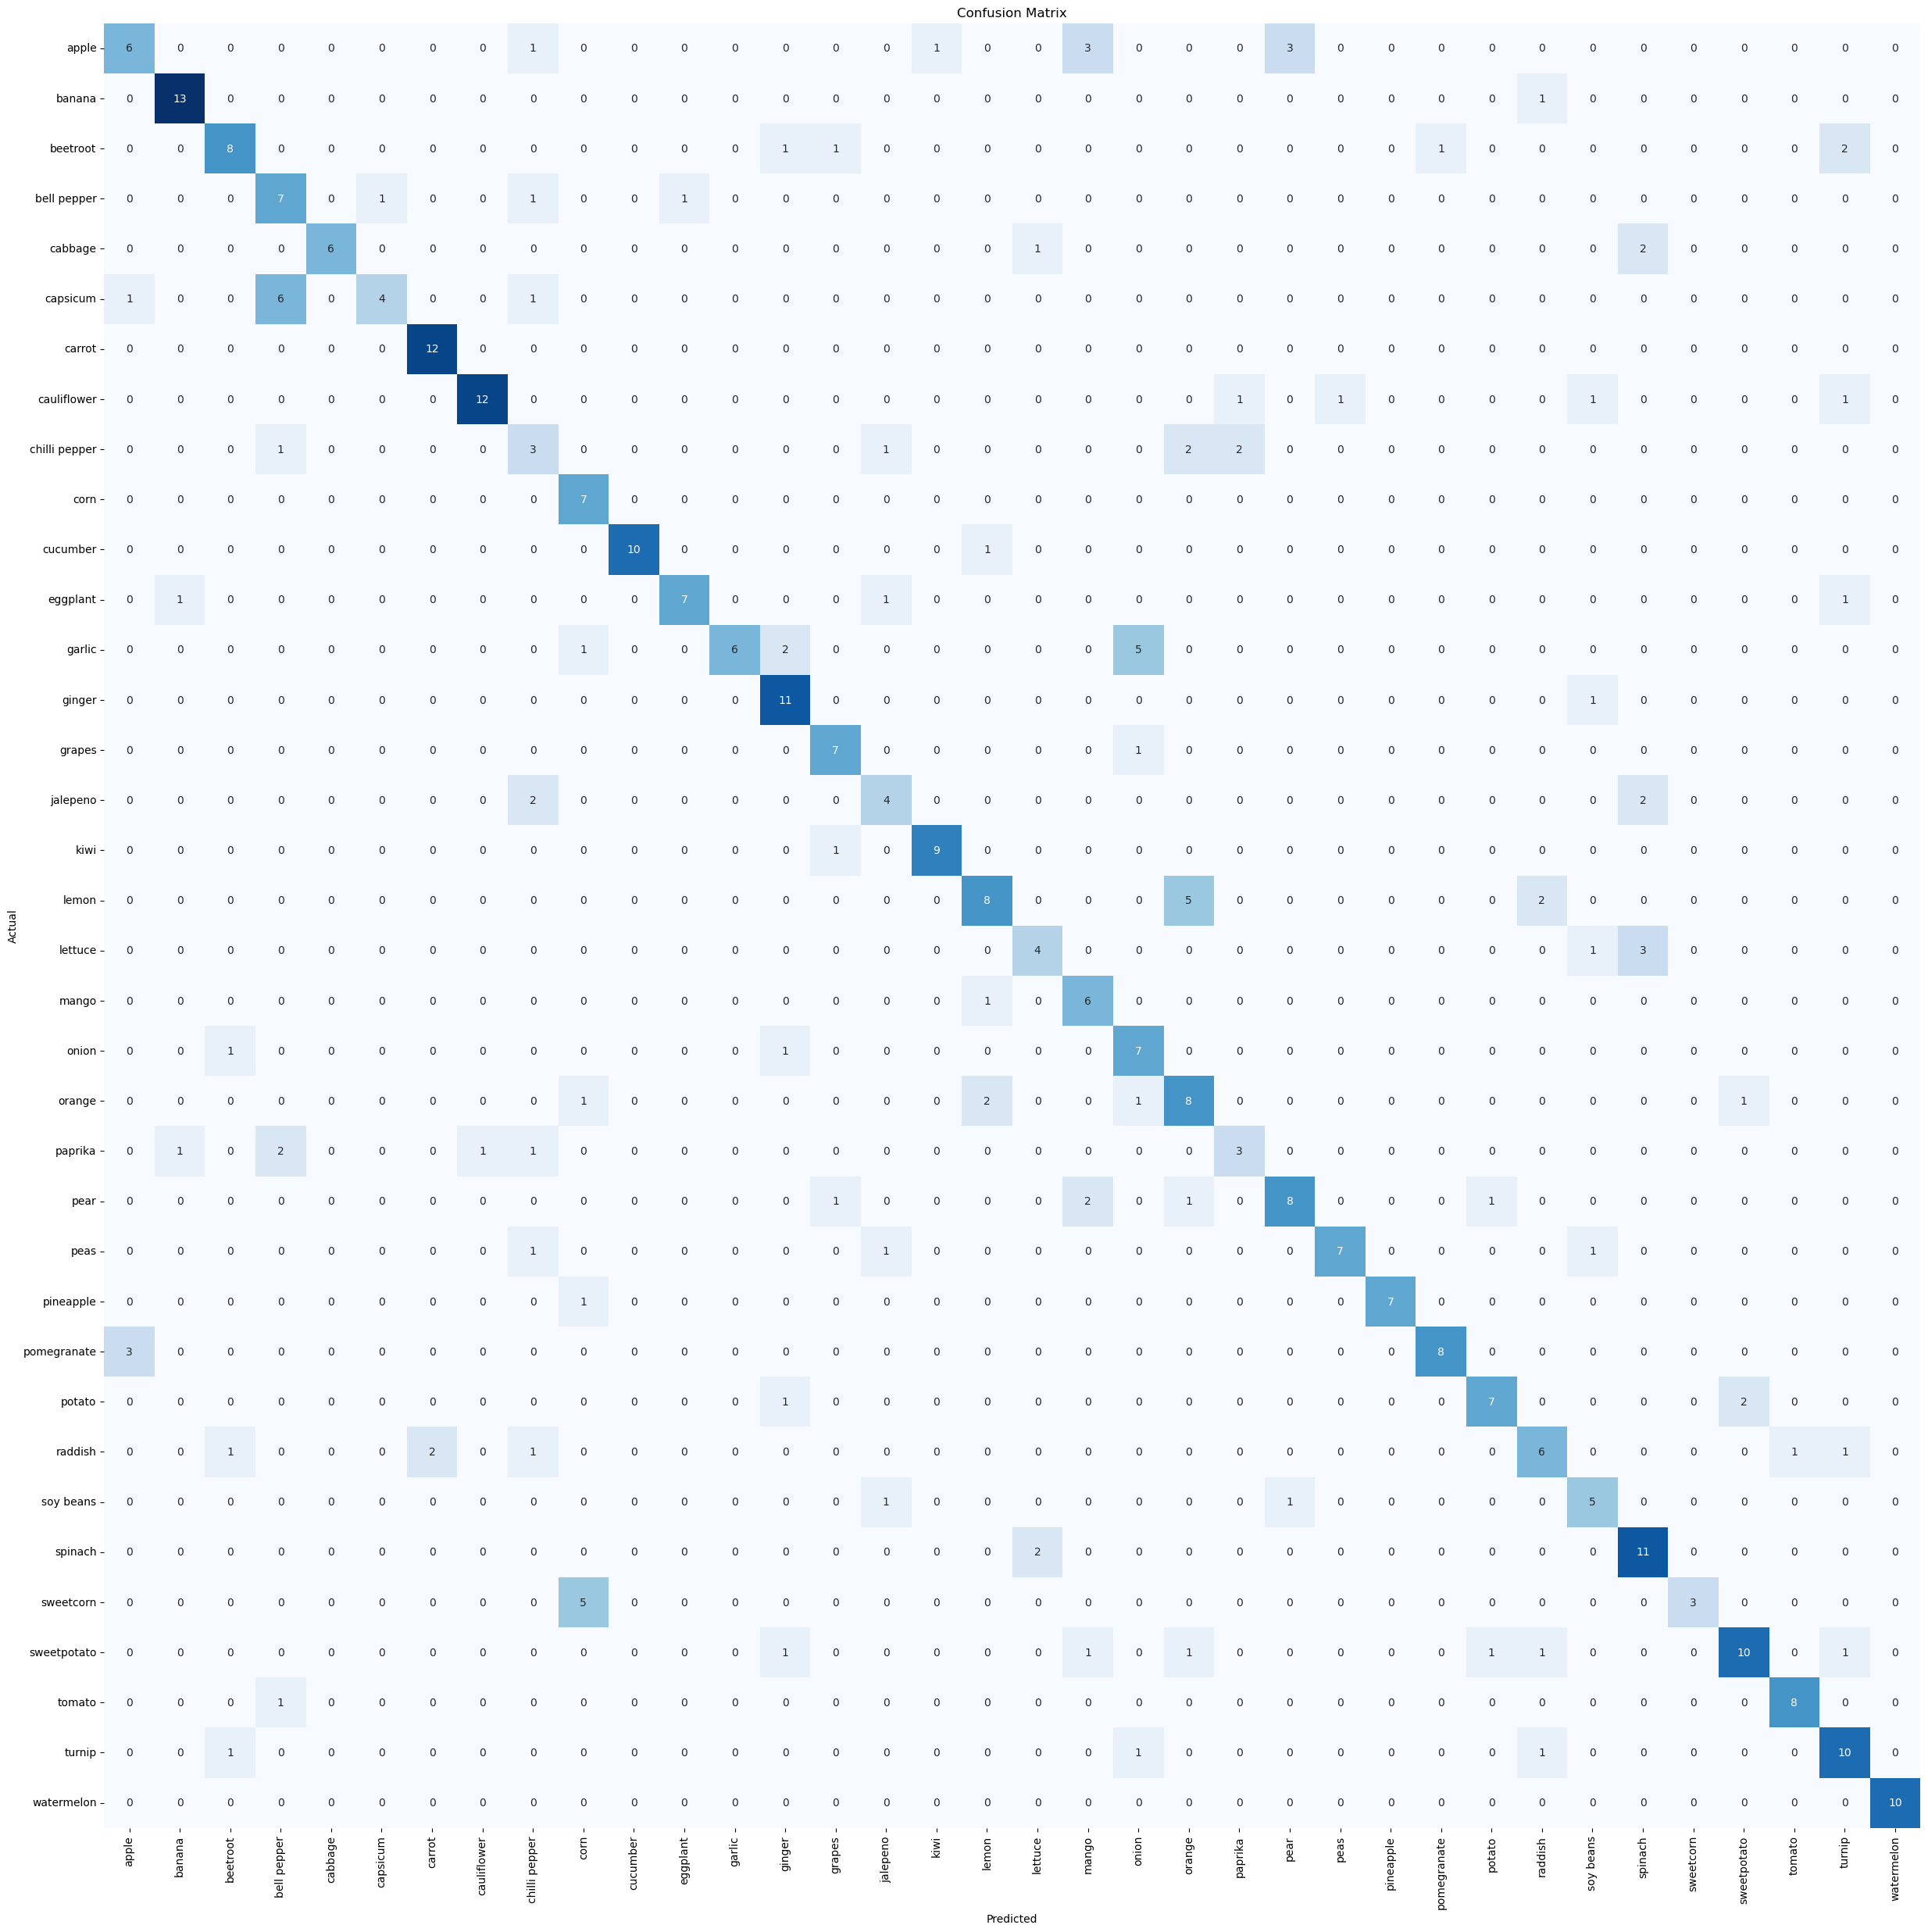

In [18]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(36) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(36) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [19]:
print("Classification Report:\n----------------------\n", clr)


Classification Report:
----------------------
                precision    recall  f1-score   support

        apple       0.60      0.43      0.50        14
       banana       0.87      0.93      0.90        14
     beetroot       0.73      0.62      0.67        13
  bell pepper       0.41      0.70      0.52        10
      cabbage       1.00      0.67      0.80         9
     capsicum       0.80      0.33      0.47        12
       carrot       0.86      1.00      0.92        12
  cauliflower       0.92      0.75      0.83        16
chilli pepper       0.27      0.33      0.30         9
         corn       0.47      1.00      0.64         7
     cucumber       1.00      0.91      0.95        11
     eggplant       0.88      0.70      0.78        10
       garlic       1.00      0.43      0.60        14
       ginger       0.65      0.92      0.76        12
       grapes       0.70      0.88      0.78         8
     jalepeno       0.50      0.50      0.50         8
         kiwi    